In [25]:
import math
import h5py
import numpy as np
import netCDF4 as nc
#from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt
import time
import pandas as pd
import datetime
import random
import copy

import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import from_numpy
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn
import torch.optim as optim


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from functools import partial

2.1.0a0+29c30b1


In [45]:
class Net(nn.Module):
    def __init__(self, p, p2d):
        super(Net, self).__init__()
        self.p = p
        self.p2d = p2d
        self.conv1 = nn.Conv2d(1, 32, stride = (3,3), kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, stride = (2,2), kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 4 * 6, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)  # 1 output value
        self.dropout2d = nn.Dropout2d(p = self.p2d)
        self.dropout = nn.Dropout(p = self.p)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout2d(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout2d(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 8 * 4 * 6)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model=Net(0.1, 0.1)
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=192, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (dropout2d): Dropout2d(p=0.1, inplace=False)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [46]:
ds3 = xr.open_dataset("real_world_sst.nc", decode_times=False)
#ds2 = xr.open_dataset("/content/drive/MyDrive/CaliforniaClimateCapstone/Data/Detrended_SST.nc", decode_times=False)
ds3

<xarray.Dataset> Size: 33MB
Dimensions:  (time: 74, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 592B 0 365 730 1096 1461 ... 25567 25933 26298 26663
Data variables:
    SST      (time, lat, lon) float64 33MB ...

In [47]:
PRECT_real = pd.read_csv('real_world_prect.csv')
#PRECT = pd.read_csv('/content/drive/MyDrive/CaliforniaClimateCapstone/Data/Detrended_PRECT.csv')
PRECT_real = PRECT_real.set_index(['year', 'region'])
PRECT_real.drop(columns=['Unnamed: 0'], inplace=True)
PRECT_real.head()

,,PRECT
year,region,
1950,North,-1.252478
1951,North,6.405958
1952,North,0.244133
1953,North,-1.394033
1954,North,-9.740346


In [48]:
PRECT_real.iloc[72:144]

,,PRECT
year,region,
1950,Central,-0.238446
1951,Central,5.686935
1952,Central,-2.287565
1953,Central,-1.109147
1954,Central,-2.598390
...,...,...
2017,Central,-1.968045
2018,Central,5.493383
2019,Central,-2.887452


In [49]:
y= PRECT_real.to_numpy()
y.shape

(216, 1)

In [50]:
y = y[72:144]
y.shape

(72, 1)

In [51]:
X = ds3['SST'].to_numpy()

In [52]:
X = X[:72, :, :]
X.shape

(72, 192, 288)

In [53]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [54]:
BATCH_SIZE = 32
X_train = X[:40,:,:]
X_test = X[40:, :, :]
y_train = y[:40,:]
y_test = y[40:, :]

X_train = from_numpy(X_train).float()
y_train = from_numpy(y_train).float()

X_test = from_numpy(X_test).float()
y_test = from_numpy(y_test).float()

X_train = X_train.view(-1, 192, 288)
y_train = y_train.view(-1, 1)

X_test = X_test.view(-1, 192, 288)
y_test = y_test.view(-1, 1)

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False)
dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)


In [55]:
train_losses = []
valid_losses = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    epoch_loss = 0  # Initialize epoch loss
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X = X.unsqueeze(1)
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        # Compute prediction and loss
        pred = model(X)

        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

        if batch % 36 == 0:
            loss, current = loss.item(), batch * BATCH_SIZE + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    epoch_avg_loss = epoch_loss / num_batches
    train_losses.append(epoch_avg_loss)


def test_valid_loop(dataloader, model, loss_fn, valid = True):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            # Prepare Data
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            X = X.unsqueeze(1)
            # make predictions and calculate loss and accuracy
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    
    # Print either Validation or Test error
    if valid:
      print(f"Validation Loss: {test_loss:>8f} \n")
      valid_losses.append(test_loss)
    else:
      print(f"Test Loss: {test_loss:>8f} \n")

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [57]:
# Train model and evaluate on validation set for each epoch

# Optimal values from performance:
tuned_p = 0.5
tuned_p2 = 0.1
tuned_lr = 0.0001

model = Net(tuned_p, tuned_p2)
model.to(device)

# Freeze all layers except the final FC layer
for param in model.parameters():
    param.requires_grad = False

# Set requires_grad=True for parameters in the final FC layer
for param in model.fc3.parameters():
    param.requires_grad = True

#ADD PATH FOR BEST MODEL WEIGHTS
model.load_state_dict(torch.load('12kparams_model_weights_r2_1434.pth', map_location=device))

# Optionally, you might want to move your model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=tuned_lr)
epochs = 20

best_loss = np.inf
#patience = 30
#no_improvement_counter = 0

train_losses = []
valid_losses = []

for t in range(epochs):
    
    # if no_improvement_counter >= patience:
    #     break

    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer)
    #test_valid_loop(dataloader_valid, model, loss_fn)

    # if valid_losses[t] < best_loss:
    #     best_loss = valid_losses[t]
    #     no_improvement_counter = 0
    #     best_model_weights = copy.deepcopy(model.state_dict())
    # else:
    #     no_improvement_counter += 1
    
print("Done!")

Epoch 1
-------------------------------
loss: 16.583008  [   32/   40]
Epoch 2
-------------------------------
loss: 15.769116  [   32/   40]
Epoch 3
-------------------------------
loss: 15.661225  [   32/   40]
Epoch 4
-------------------------------
loss: 15.908129  [   32/   40]
Epoch 5
-------------------------------
loss: 14.774954  [   32/   40]
Epoch 6
-------------------------------
loss: 16.468079  [   32/   40]
Epoch 7
-------------------------------
loss: 16.292620  [   32/   40]
Epoch 8
-------------------------------
loss: 15.303783  [   32/   40]
Epoch 9
-------------------------------
loss: 16.194233  [   32/   40]
Epoch 10
-------------------------------
loss: 15.466213  [   32/   40]
Epoch 11
-------------------------------
loss: 16.640797  [   32/   40]
Epoch 12
-------------------------------
loss: 14.852622  [   32/   40]
Epoch 13
-------------------------------
loss: 16.041807  [   32/   40]
Epoch 14
-------------------------------
loss: 16.112061  [   32/   40]
E

In [60]:
def r_squared(actual, predicted):
    # Calculate mean of actual values
    mean_actual = np.mean(actual)
    
    # Calculate sum of squared differences between actual and predicted values
    ss_residual = np.sum((actual - predicted) ** 2)
    
    # Calculate sum of squared differences between actual and mean values
    ss_total = np.sum((actual - mean_actual) ** 2)
    
    # Calculate R-squared
    r2 = 1 - (ss_residual / ss_total)
    
    return r2


actual_values = np.array(y_test.squeeze(1))

# # Instantiate model
# model_best_weights = Net(tuned_p, tuned_p)
# model_best_weights.to(device)

# # Load the best model weights
# model_best_weights.load_state_dict(best_model_weights)

#model_best_weights.load_state_dict(torch.load('12kparams_model_weights_r2_1434.pth', map_location=device))

X_test.to(device)
# Set the model to evaluation mode
#model_best_weights.eval()
model.eval()
#predicted_values = model_best_weights(X_test.unsqueeze(1).to(device)).squeeze(1).detach().cpu().numpy()
predicted_values = model(X_test.unsqueeze(1).to(device)).squeeze(1).detach().cpu().numpy()

r_squared_value = r_squared(actual_values, predicted_values)
print("R-squared:", r_squared_value)

#torch.save(model.state_dict(), 'finetuned_biasincluded_maxpool_2473r2.pth')

R-squared: 0.2473517656326294


R2: 0.24735

Inital weights: from R2 of 14.34 model

Bias: Yes

Pooling: Max

Epochs: 20

tuned_p = 0.5

tuned_p2 = 0.1

tuned_lr = 0.0001

In [62]:
pred_dict = dict()
pred_dict2 = dict()

for i in range(32):
    pred_dict[i] = actual_values[i]
    pred_dict2[i] = predicted_values[i]

actual_df = pd.DataFrame(list(pred_dict.items()), columns=['Year', 'Actual PRECT'])
pred_df = pd.DataFrame(list(pred_dict2.items()), columns=['Year', 'Predicted PRECT'])

# Merge the DataFrames on 'Epoch' column
actual_pred_df = pd.merge(actual_df, pred_df, on='Year')

#actual_pred_df


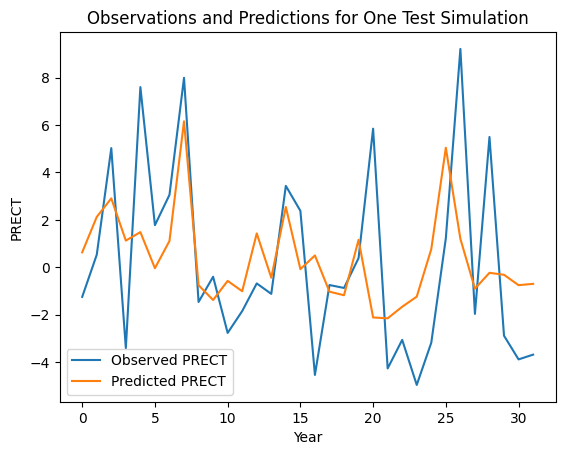

In [63]:
plt.plot(actual_pred_df['Year'], actual_pred_df['Actual PRECT'], label='Observed PRECT')
plt.plot(actual_pred_df['Year'], actual_pred_df['Predicted PRECT'], label='Predicted PRECT')
plt.xlabel('Year')
plt.ylabel('PRECT')
plt.title('Observations and Predictions for One Test Simulation')
plt.legend()
plt.show()